In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/dsKal100

/content/drive/MyDrive/Github/dsKal100


In [ ]:
!ls

 cs-231n-python-colab.ipynb   lec
 disc			      other
 grad_proj		      proj
 hw			     'python-tutorial for cs231n Stanford.ipynb'
 lab			      README.md


In [3]:
%cd lec/lec10
!ls

/content/drive/MyDrive/Github/dsKal100/lec/lec10
bulge.png  data  lec10.ipynb


# Lab 5: Modeling, Loss Functions, and Summary Statistics

**This assignment should be completed and submitted by Tuesday, February 22nd, 2022 at 11:59 PM PT**.


### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

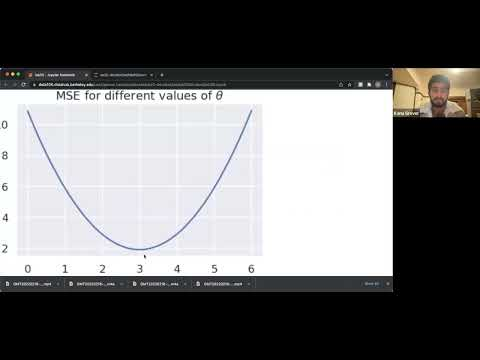

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("V-PRSCA-3qc")

### Collaboration Policy

Data science is a collaborative activity. While you may talk to others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** in the following cell:

**Collaborators**: *List names here*

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Predicting Restaurant Tips

In this lab, you will try to predict restaurant tips from a set of data in several ways:

A. Without given any additional information, use a **constant model with L2 loss** to predict the tip $\hat{y}$ as a summary statistic, $\theta$.

B. Given one piece of information—the total bill $x$—**use a linear model with L2 loss** to predict the tip $\hat{y}$ as a linear function of $x$.

C. See if a **constant model with L1 loss** changes our predictions.

First, let's load in the data.

In [4]:
# just run this cell
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")

In [5]:
tips = sns.load_dataset("tips")

In [6]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [7]:
tips.shape

(244, 7)

In [10]:
display(tips.size)
display(tips.shape[0]*tips.shape[1])

1708

1708

In [11]:
len(tips)

244

In [12]:
tips["pct"] = tips.tip/tips.total_bill

In [13]:
tips.describe()

,total_bill,tip,size,pct
count,244.000000,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672,0.160803
std,8.902412,1.383638,0.951100,0.061072
min,3.070000,1.000000,1.000000,0.035638
25%,13.347500,2.000000,2.000000,0.129127
50%,17.795000,2.900000,2.000000,0.154770
75%,24.127500,3.562500,3.000000,0.191475
max,50.810000,10.000000,6.000000,0.710345


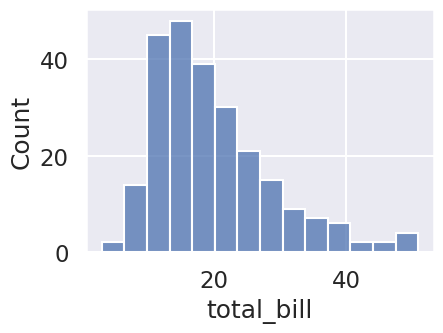

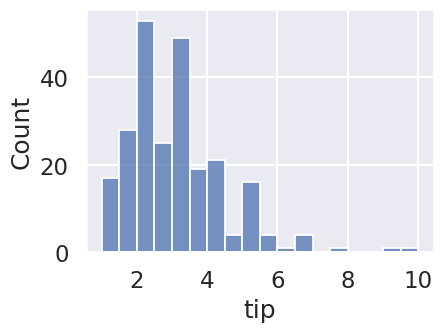

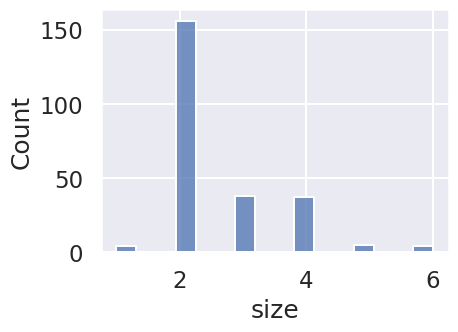

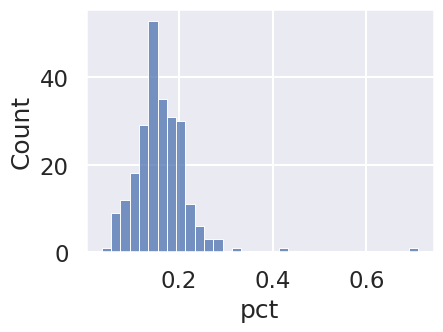

In [22]:
num_cols = ["total_bill", "tip", "size", "pct"]
def histo(data, col):
  fig, ax = plt.subplots(figsize=(4, 3))
  sns.histplot(data=data, x=col) #note, don't have to say ax=ax[0] or ax=ax here even though we defined it
  plt.show()

for col in num_cols:
  histo(tips, col)

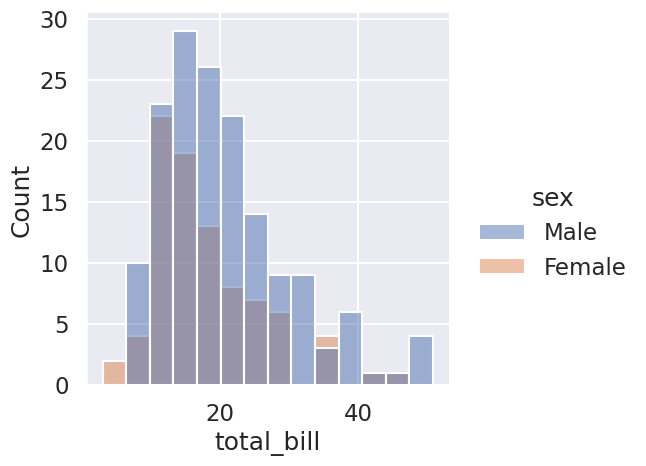

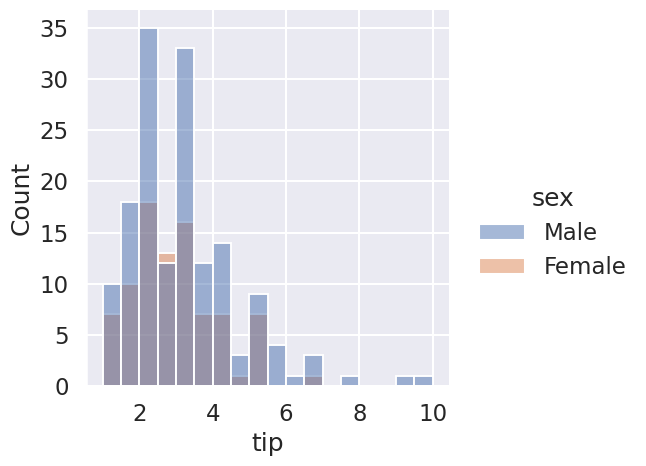

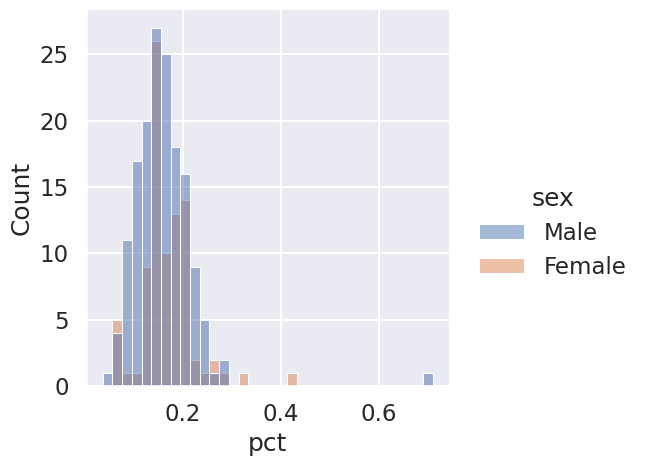

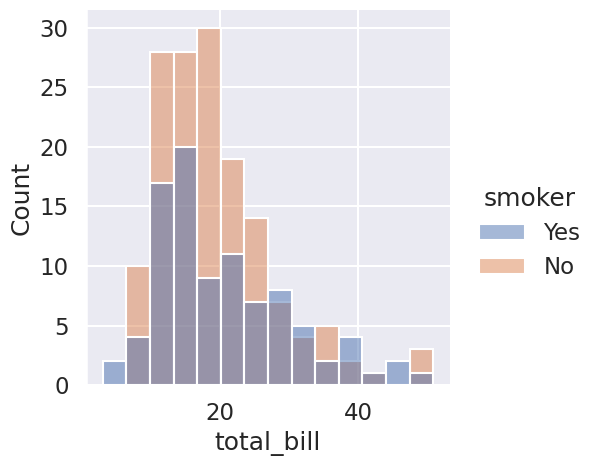

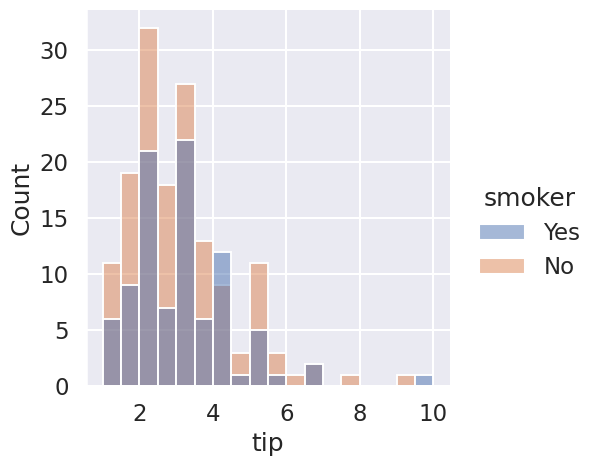

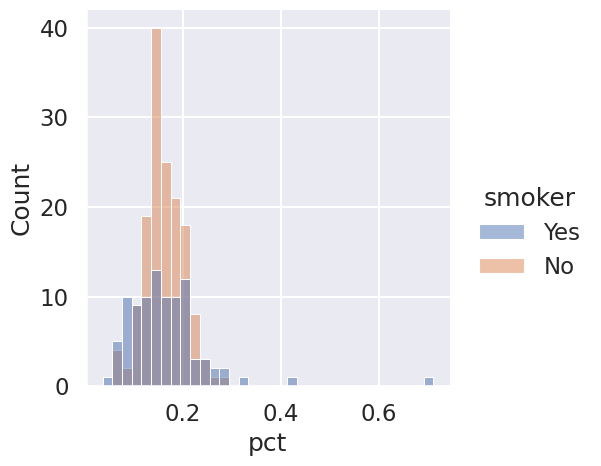

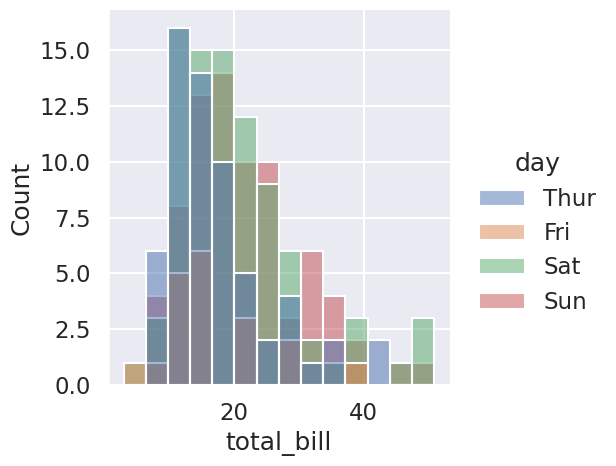

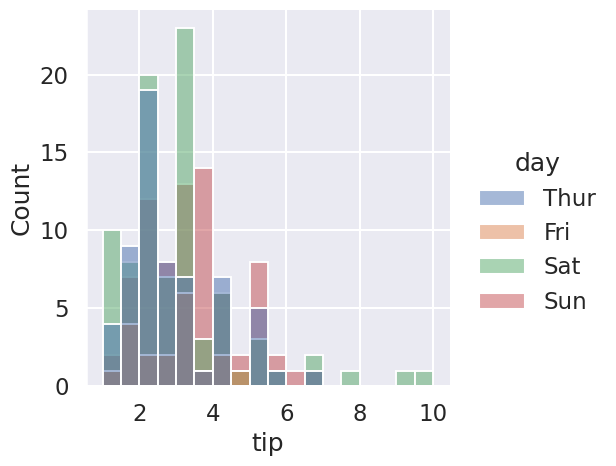

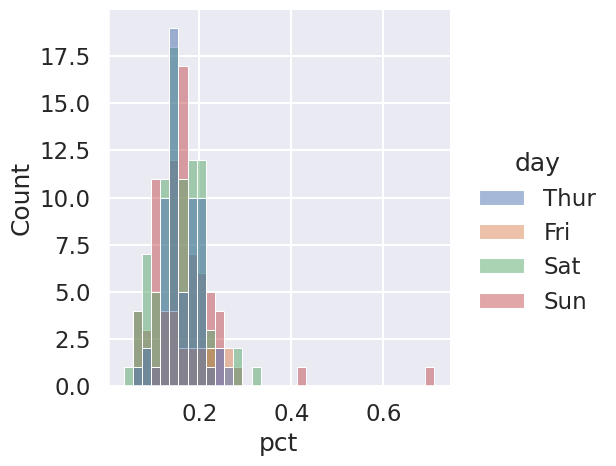

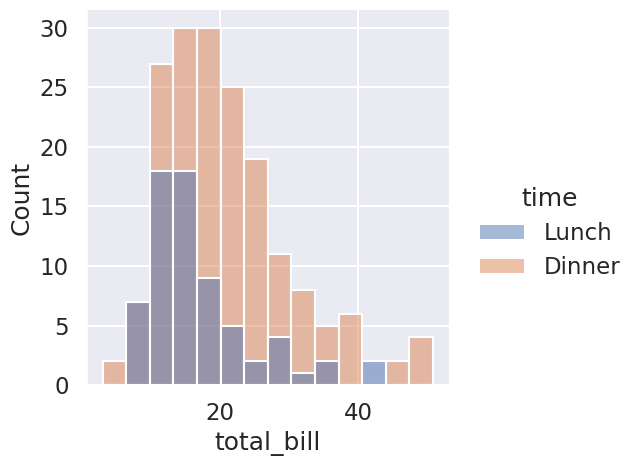

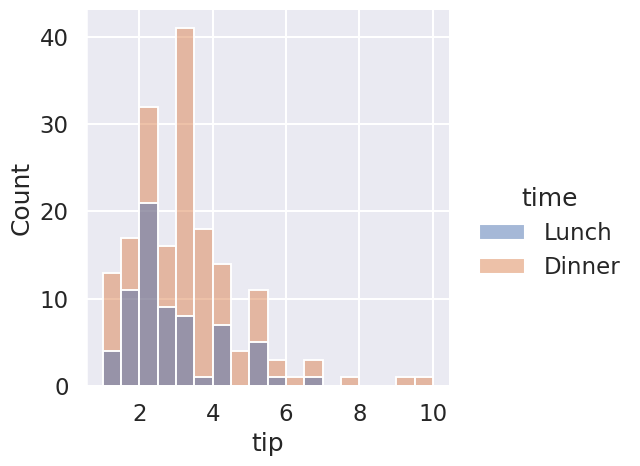

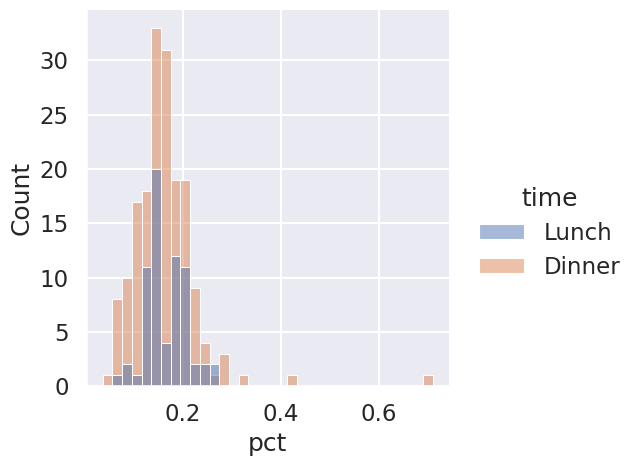

In [23]:
num_cols = ["total_bill", "tip", "pct"]  #size doesn't seem important
hue_cols = ["sex", "smoker", "day", "time"]
def histo(data, col, hue):
  sns.displot(data=data, x=col, hue=hue)
  plt.show()

#smoker
for hue in hue_cols:
  for col in num_cols:
    histo(tips, col, hue)


**Quick EDA**: Note that this dataset is likely from the United States. The below plot graphs the distribution of tips in this dataset, both in absolute amounts ($) and as a fraction of the total bill (post-tax, but pre-tip).

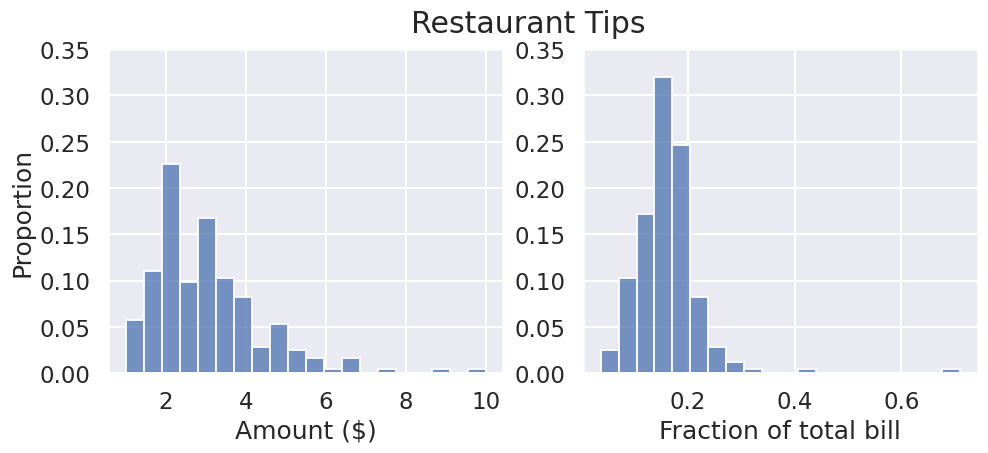

In [24]:
# just run this cell
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.histplot(tips['tip'], bins=20, stat="proportion", ax=ax[0])
sns.histplot(tips['tip']/tips['total_bill'], bins=20, stat="proportion", ax=ax[1])
ax[0].set_xlabel("Amount ($)")
ax[1].set_xlabel("Fraction of total bill")
ax[0].set_ylim((0, 0.35))
ax[1].set_ylim((0, 0.35))
ax[1].set_ylabel("") # for cleaner visualization
fig.suptitle("Restaurant Tips")
plt.show()

In this lab we'll estimate the tip in **absolute amounts ($)**. The above plot is just to confirm your expectations about the `tips` dataset.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Part A: Tips as a Summary Statistic

Let's first predict any restaurant tip using one single number: in other words, let's try to find the best statistic $\hat{\theta}$ to represent (i.e., **summarize**) the tips from our dataset.

Each actual tip in our dataset is $y$, which is what we call the **observed value**. We want to predict each observed value as $\hat{y}$. We'll save the observed tip values in a NumPy array `y_tips`:

In [26]:
# just run this cell
# saves the "tips" column as a numpy array
y_tips = np.array(tips['tip']) # array of observed tips
display(y_tips.shape)
len(y_tips)

(244,)

244


Recall the three-step process for modeling as covered in lecture:

1. Define a **model.**

1. Define a **loss function** and the associated **risk** on our training dataset (i.e., average loss).

1. Find the best value of $\theta$, known as $\hat{\theta}$, that **minimizes** risk.

We'll go through each step of this process next.

<br/>
<hr style="border: 1px solid #fdb515;" />

## A.1: Define the model

We will define our model as the **constant model**:

$$\Large
\hat{y} = \theta
$$

In other words, regardless of any other details (i.e., features) about their meal, we will always predict our tip $\hat{y}$ as one single value: $\theta$.


$\theta$ is what we call a **parameter**. Our modeling goal is to find the value of our parameter(s) that **best fit our data**.
We have choice over which $\theta$ we pick (using the data at hand), but ultimately we can only pick one to report, so we want to find the optimal parameter(s) $\hat{\theta}$.

We call the constant model a **summary statistic**, as we are determining one number that best "summarizes" a set of values.


No code to write here!


<br/>
<hr style="border: 1px solid #fdb515;" />

## A.2: Define the loss function and risk

Next, in order to pick our $\theta$, we need to define a **loss function**, which is a measure of how well a model is able to predict the expected outcome. In other words, it measures the deviation of a predicted value $\hat{y}$ from the observed value $y$.

We will use **squared loss** (also known as the $L_2$ loss, pronounced "ell-two"). For an observed tip value $y$ (i.e., the real tip), our prediction of the tip $\hat{y}$ would give an $L_2$ loss of:

$$\Large L_2(y, \hat{y}) = (y - \hat{y})^2$$


---
## Question 1

In our constant model  $\hat{y} = \theta$, we always predict the tip as $\theta$. Therefore our $L_2$ loss for some actual, observed value $y$ can be rewritten as:

$$\Large L_2(y, \theta) = (y - \theta)^2$$

Use the function description below to implement the squared loss function for this single datapoint, assuming the constant model. Your answer should not use any loops.


<!--
BEGIN QUESTION
name: q1
-->

In [27]:
def squared_loss(y_obs, theta):
    """
    Calculate the squared loss of the observed data and a summary statistic.

    Parameters
    ------------
    y_obs: an observed value
    theta : some constant representing a summary statistic

    Returns
    ------------
    The squared loss between the observation and the summary statistic.
    """
    return (y_obs - theta)**2

<br/><br/>

We just defined loss for a single datapoint. Let's extend the above loss function to our entire dataset by taking the **average loss** across the dataset.

Let the dataset $\mathcal{D}$ be the set of observations: $\mathcal{D} = \{y_1, \ldots, y_n\}$, where $y_i$ is the $i^{th}$ tip (this is the `y_tips` array defined at the beginning of Part A).

We can define the average loss (aka **risk**) over the dataset as:

$$\Large
R\left(\theta\right) = \frac{1}{n} \sum_{i=1}^n L(y_i, \hat{y_i})
$$

If we use $L_2$ loss per datapoint ($L = L_2$), then the risk is also known as **mean squared error** (MSE). For the constant model $\hat{y}=\theta$:

$$\Large
R\left(\theta\right) = \frac{1}{n} \sum_{i=1}^n (y_i - \theta)^2
$$

---

## Question 2

Define the `mse_tips_constant` function which computes $R(\theta)$ as the **mean squared error** on the tips data for a constant model with parameter $\theta$.

Notes/Hints:
* This function takes in one parameter, `theta`; `data` is defined for you as a NumPy array that contains the observed tips values in the data.
* Use the `squared_loss` function you defined in the previous question.

<!--
BEGIN QUESTION
name: q2
-->

In [28]:
def mse_tips_constant(theta):
    data = y_tips
    return np.mean((y_tips - theta)**2)

mse_tips_constant(5.3) # arbitrarily pick theta = 5.3

7.20452950819672

In [31]:
np.sum((y_tips - 5.3)**2)

1757.9051999999997

In [30]:
np.sum((y_tips - 5.3)**2)/len(y_tips)

7.20452950819672


<br/>
<hr style="border: 1px solid #fdb515;" />

## A.3: Find the $\theta$ that minimizes risk

## Question 3
Now we can go about choosing our "best" value of $\theta$, which we call $\hat{\theta}$, that minimizes our defined risk (which we defined as mean squared error). There are several approaches to computing $\hat{\theta}$ that we'll explore in this problem.

---

### Question 3a: Visual Solution

In the cell below  we plot the mean squared error for different thetas:

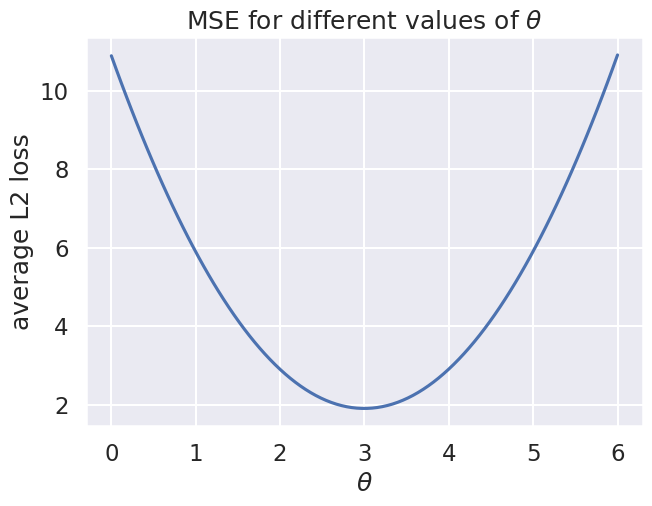

In [33]:
# just run this cell
theta_values = np.linspace(0, 6, 100)
mse = [mse_tips_constant(theta) for theta in theta_values]
plt.plot(theta_values, mse)
plt.xlabel(r'$\theta$')
plt.ylabel('average L2 loss')
plt.title(r'MSE for different values of $\theta$');

Find the value of `theta` that minimizes the mean squared error via observation of the plot above. Round your answer to the nearest integer.

<!--
BEGIN QUESTION
name: q3a
-->

<Axes: >

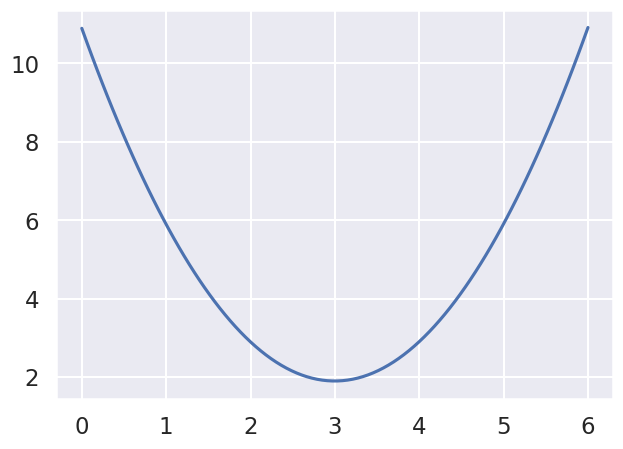

In [35]:
#with seaborn
sns.lineplot(y=mse, x=theta_values)

In [36]:
min(mse)

1.907425427147782

In [39]:
#finds the index value of the min number in the mse np.array
#returns the value for theta which corresponds to the min mse
min_observed_mse = theta_values[np.argmin(mse)]
display(min_observed_mse)
display(np.argmin(mse))
theta_values[49]

2.9696969696969697

49

2.9696969696969697

<br/>

### Numerically computing $\hat{\theta}$

`scipy.optimize.minimize` is a powerful method that can determine the optimal value of a variety of different functions. In practice, it is used to minimize functions that have no (or difficult to obtain) analytical solutions (it is a **numerical method**).

It is overkill for our simple example, but nonetheless, we will show you how to use it, as it will become useful in the near future.

The cell below plots some arbitrary 4th degree polynomial function.

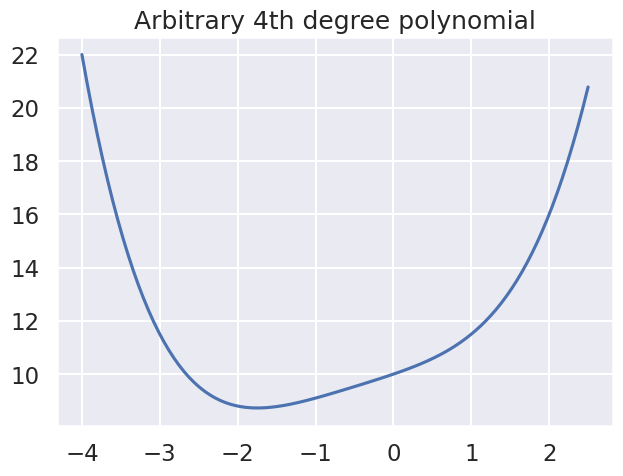

In [40]:
# just run this cell
x_values = np.linspace(-4, 2.5, 100)

def fx(x):
    return 0.1 * x**4 + 0.2*x**3 + 0.2 * x **2 + 1 * x + 10

plt.plot(x_values, fx(x_values));
plt.title("Arbitrary 4th degree polynomial");

By looking at the plot, we see that the x that minimizes the function is slightly larger than -2. What if we want the exact value? We will demonstrate how to grab the minimum value and the optimal `x` in the following cell.

The function `minimize` from [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) will attempt to minimize any function you throw at it. Try running the cell below, and you will see that `minimize` seems to get the answer correct.

Note: For today, we'll let `minimize` work as if by magic. We'll discuss how `minimize` works later in the course.

In [41]:
display(min(fx(x_values)))
display(x_values[np.argmin(fx(x_values))])

8.728937438538809

-1.7676767676767673

In [42]:
# just run this cell
from scipy.optimize import minimize
minimize(fx, x0 = 1.1)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 8.728505719866614
        x: [-1.747e+00]
      nit: 6
      jac: [ 1.192e-07]
 hess_inv: [[ 5.088e-01]]
     nfev: 16
     njev: 8

Notes:<br/>
[1] `fun`: the minimum value of the function. <br/>
[2] `x`: the x which minimizes the function. We can index into the object returned by `minimize` to get these values. We have to add the additional `[0]` at the end because the minimizing x is returned as an array, but this is not necessarily the case for other attributes (i.e. `fun`), shown in the cell below.

Note [2] means that `minimize` can also minimize multivariable functions, which we'll see in the second half of this lab.

In [43]:
# just run this cell
min_result = minimize(fx, x0 = 1.1)

min_of_fx = min_result['fun']
x_which_minimizes_fx = min_result['x'][0]
min_of_fx, x_which_minimizes_fx

(8.728505719866614, -1.746827786380178)

**Initial guess**: The parameter `x0` that we passed to the `minimize` function is where the `minimize` function starts looking as it tries to find the minimum. For example, above, `minimize` started its search at x = 1.1 because that's where we told it to start. For the function above, it doesn't really matter what x we start at because the function is nice and has only a single local minimum. More technically, the function is nice because it is [convex](https://en.wikipedia.org/wiki/Convex_function), a property of functions that we will discuss later in the course.

**Local minima**: `minimize` isn't perfect. For example, if we give it a function with many valleys (also known as local minima) it can get stuck. For example, consider the function below:

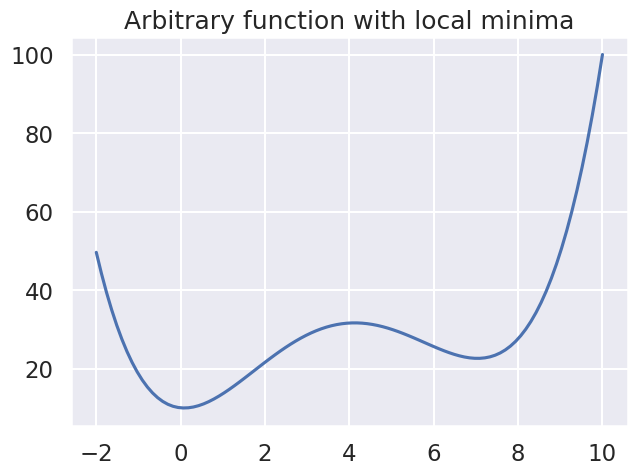

In [44]:
# just run this cell
w_values = np.linspace(-2, 10, 100)

def fw(w):
    return 0.1 * w**4 - 1.5*w**3 + 6 * w **2 - 1 * w + 10

plt.plot(w_values, fw(w_values));
plt.title("Arbitrary function with local minima");

If we start the minimization at `w` = `6.5`, we'll get stuck in the local minimum at w = `7.03`. Note that no matter what your actual variable is called in your function (`w` in this case), the `minimize` routine still expects a starting point parameter called `x0`.

In [45]:
# just run this cell
minimize(fw, x0 = 6.5)    # initial w is 6.5

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 22.594302881719713
        x: [ 7.038e+00]
      nit: 4
      jac: [-3.815e-06]
 hess_inv: [[ 1.231e-01]]
     nfev: 12
     njev: 6

---

### Question 3b: Numerical Solution

Using the `minimize` function, find the value of `theta` that minimizes the mean squared error for our `tips` dataset. In other words, you want to find the exact minimum of the plot that you saw in the previous part.

Notes:
* You should use the function you defined earlier: `mse_tips_constant`.
* For autograding purposes, assign `min_scipy` to the value of `theta` that minimizes the MSE according to the `minimize` function, called with initial `x0=0.0`.

<!--
BEGIN QUESTION
name: q3b
-->

In [46]:
# call minimize with initial x0 = 0.0
min_scipy = minimize(mse_tips_constant, x0=0.0)
min_scipy
#checks out close to visual solution above

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.9066085124966428
        x: [ 2.998e+00]
      nit: 2
      jac: [ 1.043e-07]
 hess_inv: [[ 5.000e-01]]
     nfev: 6
     njev: 3

---

### Question 3c: Analytical Solution

In lecture, we used calculus to show that the value of theta that minimizes the mean squared error for the constant model is the average (mean) of the data. Assign `min_computed` to the mean of the observed `y_tips` data, and compare this to the values you observed in questions 3a and 3b.


<!--
BEGIN QUESTION
name: q3c
-->

In [47]:
min_computed = np.mean(y_tips)
display(min_computed)
display(min_computed - min_scipy['x'][0])

2.99827868852459

-4.6115963936443904e-08

<br/><br/>
Reflecting on the lab so far, we used a 3-step approach to find the "best" summary statistic $\theta$:

1. Define the constant model $\hat{y}=\theta$.

1. Define "best": Define loss per datapoint (L2 loss) and consequently define risk $R(\theta)$ over a given data array as the mean squared error, or MSE.

1. Find the $\theta = \hat{\theta}$ that minimizes the MSE $R(\theta)$ in several ways:

    * Visually: Create a plot of $R(\theta)$ vs. $\theta$ and eyeball the minimizing $\hat{\theta}$.
    * Numerically: Create a function that returns $R(\theta)$, the MSE for the given data array for a given $\theta$, and use the scipy minimize function to find the minimizing $\hat{\theta}$.
    * Analytically: Simply compute $\hat{\theta}$ the mean of the given data array, since this minimizes the defined $R(\theta)$.
    * (a fourth analytical option) Use calculus to find $\hat{\theta}$ that minimizes MSE $R(\theta)$.
    
At this point, you've hopefully convinced yourself that the mean of the data is the summary statistic that minimizes mean squared error.

**Our prediction for every meal's tip**:

In [48]:
# just run this cell
def predict_tip_constant():
    return min_computed

# do not edit below this line
bill = 20
print(f"""No matter what meal you have, Part A's modeling process
    predicts that you will pay a tip of ${predict_tip_constant():.2f}.""")

No matter what meal you have, Part A's modeling process
    predicts that you will pay a tip of $3.00.


<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Part B: Tips as a Linear Function of Total Bill

In this section, you will follow the exact same modeling process but instead use total bill to predict tip.

We'll save the observed total bill values (post-tax but pre-tip) and the observed tip values in two NumPy arrays, `x_total_bills` and `y_tips`:

In [50]:
# just run this cell
x_total_bills = np.array(tips['total_bill']) # array of total bill amounts
y_tips = np.array(tips['tip'])              # array of observed tips
print("total bills", x_total_bills.shape)
print("tips", y_tips.shape)

total bills (244,)
tips (244,)


<br/>
<hr style="border: 1px solid #fdb515;" />

## B.1 Define the model

We will define our model as the **linear model** that takes a single input feature, `total_bill` ($x$):

$$\Large
\hat{y} = a + b x
$$

Our "parameter" $\theta$ is actually two parameters: $a$ and $b$. You may see this written as $\theta = (a, b)$.

Our modeling task is then to pick the best values $a = \hat{a}$ and $b = \hat{b}$ from our data. Then, given the total bill $x$, we can predict the tip as $\hat{y} = \hat{a} + \hat{b} x$.

No code to write here!





<br/>
<hr style="border: 1px solid #fdb515;" />

## B.2: Define the loss function and risk

Next, we'll define our loss function $L(y, \hat{y})$ and consequently our risk function $R(\theta) = R(a, b)$.

Similar to our approach to Part A, we'll use L2 Loss and Mean Squared Error. Let the dataset $\mathcal{D}$ be the set of observations: $\mathcal{D} = \{(x_1, y_1), \ldots, (x_n, y_n)\}$, where $(x_i, y_i)$ are the $i^{th}$ total bill and tip, respectively, in our dataset.

Our L2 Loss and Mean Squared Error are therefore:

\begin{align}
\large L_2(y, \hat{y}) = \large (y - \hat{y})^2 &= \large (y - (a + bx))^2 \\
\large R(a, b) = \large \frac{1}{n} \sum_{i=1}^n L(y_i, \hat{y_i}) &= \large  \frac{1}{n} \sum_{i = 1}^n(y_i - (a + b x_i))^2
\end{align}

Notice that because our model is now the linear model $\hat{y} = a + bx$, our final expressions for Loss and MSE are different from Part A.

---

## Question 4

Define the `mse_tips_linear` function which computes $R(a, b)$ as the **mean squared error** on the tips data for a linear model with parameters $a$ and $b$.

Notes:
* This function takes in two parameters `a` and `b`.
* You should use the NumPy arrays `x_total_bills` and `y_tips` defined at the beginning of Part B.
* We've included some skeleton code, but feel free to write your own as well.

<!--
BEGIN QUESTION
name: q4
-->

In [52]:
def mse_tips_linear(a,b):
  return np.mean((y_tips - (a + b*x_total_bills))**2)

In [53]:
def mse_tips_linear(a, b):
    """
    Returns average L2 loss between
    predicted y_hat values (using x_total_bills and parameters a, b)
    and actual y values (y_tips)
    """
    y_hats = a + b*(x_total_bills)
    return np.mean((y_tips - y_hats)**2)

mse_tips_linear(5, 0.1) # arbitrarily pick a = 0.9, b = 0.1

16.880924110655737


<br/>
<hr style="border: 1px solid #fdb515;" />

## B.3: Find the $\theta$ that minimizes risk

Similar to before, we'd like to try out different approaches to finding the optimal parameters $\hat{a}$ and $\hat{b}$ that minimize MSE.


<br/>

---

## Question 5: Analytical Solution

In lecture, we derived the following expression for the line of best fit:

$$\Large \hat{y_i} = \bar{y} + r \frac{SD(y)}{SD(x)} (x_i - \bar{x})$$

where $\bar{x}$, $\bar{y}$, $SD(x)$, $SD(y)$ correspond to the means and standard deviations of $x$ and $y$, respectively, and $r$ is the correlation coefficient.

### Question 5a

Assign `x_bar`, `y_bar`, `std_x`, `std_y`, and `r`, for our dataset. Note: Make sure to use `np.std`, and not `<Series name>.std()`.

- Hint: Remember, in our case, `y` is `y_tips`, and `x` is `x_total_bills`.
- Hint: You may find `np.corrcoef` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html)) handy in computing `r`. Note that the output of `np.corrcoef` is a matrix, not a number, so you'll need to collect the correlation coefficient by indexing into the returned matrix.

<!--
BEGIN QUESTION
name: q5a
-->

In [54]:
x_bar = np.mean(x_total_bills)
y_bar = np.mean(y_tips)
std_x = np.std(x_total_bills)
std_y = np.std(y_tips)
r = np.corrcoef(x_total_bills, y_tips)[0,1]

### Question 5b

Now, set `b_hat` and `a_hat` correctly, in terms of the variables you defined above.

Hints:
* Try and match the slope and intercept in $\hat{y_i} = \hat{a} + \hat{b}x_i$ to the slope and intercept in $\hat{y_i} = \bar{y} + r \frac{SD(y)}{SD(x)} (x_i - \bar{x})$.
* You may want to define `a_hat` in terms of `b_hat`.

<!--
BEGIN QUESTION
name: q5b
-->

In [55]:
b_hat = r*(std_y/std_x)
a_hat = y_bar - b_hat*x_bar
a_hat, b_hat

(0.9202696135546735, 0.10502451738435335)

In [56]:
#check results with scipy stats package
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x_total_bills, y_tips)
slope, intercept, r_value, p_value, std_err

(0.1050245173843534,
 0.9202696135546726,
 0.6757341092113641,
 6.692470646864404e-34,
 0.007364789848762602)

<Axes: xlabel='total_bill', ylabel='tip'>

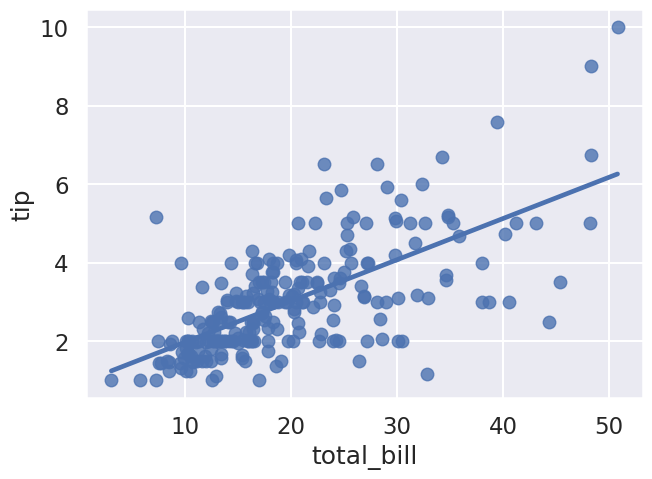

In [57]:
sns.regplot(data=tips, x="total_bill", y="tip", ci=None)


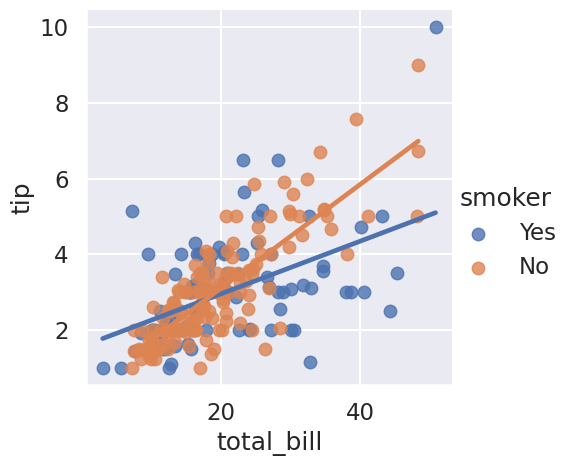

In [61]:
sns.lmplot(data=tips, x="total_bill", y="tip", ci=None, hue="smoker")

---

### Question 5c

Now, use `a_hat` and `b_hat` to implement the `predict_tip_linear` function, which predicts the tip for a total bill amount of `bill`.

<!--
BEGIN QUESTION
name: q5c
-->

In [62]:
def predict_tip_linear(bill):
    return a_hat + b_hat*bill

# do not edit below this line
bill = 20
print(f"""If you have a ${bill} bill, Part B's modeling process
    predicts that you will pay a tip of ${predict_tip_linear(bill):.2f}.""")

If you have a $20 bill, Part B's modeling process
    predicts that you will pay a tip of $3.02.



<br/>

---

## Numerically computing $\hat{\theta}$
The `minimize` function we introduced earlier can also minimize functions of multiple variables (useful for numerically computing $\hat{a}$ and $\hat{b}$. There's one quirk, however, which is that the function has to accept its parameters as a single list.

For example, consider the multivariate $f(u, v) = u^2 - 2 u v - 3 v + 2 v^2$. It turns out this function's minimum is at $(1.5, 1.5)$. To minimize this function, we create `f`.



In [63]:
# just run this cell
def f(theta):
    u = theta[0]
    v = theta[1]
    return u**2 - 2 * u * v - 3 * v + 2 * v**2

minimize(f, x0 = [0.0, 0.0])

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -2.2499999999999982
        x: [ 1.500e+00  1.500e+00]
      nit: 3
      jac: [-5.960e-08  0.000e+00]
 hess_inv: [[ 1.000e+00  5.000e-01]
            [ 5.000e-01  5.000e-01]]
     nfev: 12
     njev: 4

---

## Question 6: Numerical Solution

### Question 6a

Implement the `mse_tips_linear_list` function, which is exactly like `mse_tips_linear` defined in Question 4 except that it takes in a single list of 2 variables rather than two separate variables. For example `mse_tips_linear_list([2, 3])` should return the same value as `mse_tips_linear(2, 3)`.

<!--
BEGIN QUESTION
name: q6a
-->

In [64]:
def mse_tips_linear_list(theta):
    """
    Returns average L2 loss between
    predicted y_hat values (using x_total_bills and linear params theta)
    and actual y values (y_tips)
    """
    a = theta[0]
    b = theta[1]
    y_hat = a + b*x_total_bills
    return np.mean((y_tips - y_hat)**2)

---
### Question 6b

Now, set `min_scipy_linear` to the result of calling minimize to optimize the risk function you just implemented.

Hint: Make sure to set `x0`, say, to `[0.0, 0.0]`.

<!--
BEGIN QUESTION
name: q6b
-->

In [65]:
# call minimize with initial x0 = [0.0, 0.0]
min_scipy_linear = minimize(mse_tips_linear_list, x0=[0.0,0.0])
min_scipy_linear
#checks out!

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.0360194420114932
        x: [ 9.203e-01  1.050e-01]
      nit: 3
      jac: [-4.470e-08 -2.980e-08]
 hess_inv: [[ 2.980e+00 -1.253e-01]
            [-1.253e-01  6.335e-03]]
     nfev: 15
     njev: 5

Based on the above output from your call to `minimize`, running the following cell will set and print the values of `a_hat` and `b_hat`.

In [66]:
# just run this cell
a_hat_scipy = min_scipy_linear['x'][0]
b_hat_scipy = min_scipy_linear['x'][1]
a_hat_scipy, b_hat_scipy

(0.9202703450693733, 0.10502447914641161)

<br/>
<br/>

The following cell will print out the values of `a_hat` and `b_hat` computed from both methods ("manual" refers to the analytical solution in Question 5; "scipy" refers to the numerical solution in Question 6). If you've done everything correctly, these should be very close to one another.

In [67]:
# just run this cell
print('a_hat_scipy: ', a_hat_scipy)
print('a_hat_manual: ', a_hat)
print('\n')
print('b_hat_scipy: ', b_hat_scipy)
print('b_hat_manual: ', b_hat)

a_hat_scipy:  0.9202703450693733
a_hat_manual:  0.9202696135546735


b_hat_scipy:  0.10502447914641161
b_hat_manual:  0.10502451738435335




---
**Visual Solution** (not graded): Feel free to interact with the below plot and verify that the $\hat{a}$ and $\hat{b}$ you computed using either method above minimize the MSE. In the cell below  we plot the mean squared error for different parameter values. Note that now that we have two parameters, we have a 3D MSE surface plot.

Rotate the data around and zoom in and out using your trackpad or the controls at the top right of the figure. If you get an error that your browser does not support webgl, you may need to restart your kernel and/or browser.

In [68]:
# just run this cell
import itertools
import plotly.graph_objects as go

a_values = np.linspace(-1, 1, 80)
b_values = np.linspace(-1,1, 80)
mse_values = [mse_tips_linear(a, b) \
              for a, b in itertools.product(a_values, b_values)]
mse_values = np.reshape(mse_values, (len(a_values), len(b_values)), order='F')
fig = go.Figure(data=[go.Surface(x=a_values, y=b_values, z=mse_values)])
fig.update_layout(
    title=r'MSE for different values of $a, b$',
    autosize=False,
    scene = dict(
                    xaxis_title='x=a',
                    yaxis_title='y=b',
                    zaxis_title='z=MSE'),
                    width=500,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()


<br/>

---

### Comparing Constant Model vs Linear Model
At this point, we can actually compare our two models! Both the linear model and constant model were optimized using the same L2 loss function but predict different values for different tips.

Run the cell below:

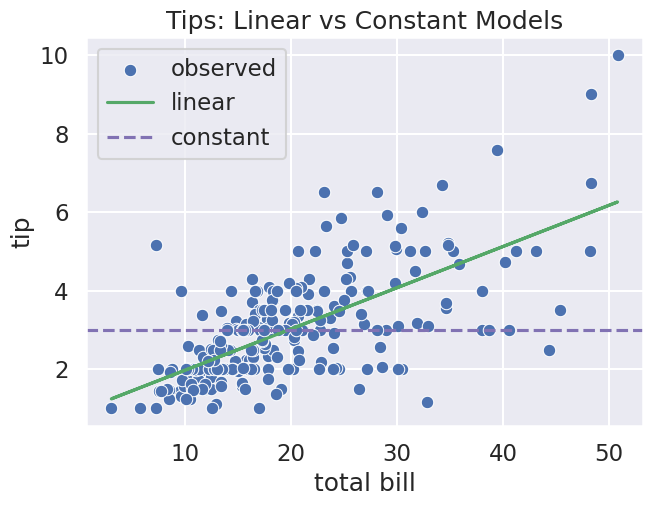

In [72]:
sns.scatterplot(x = x_total_bills, y = y_tips, label='observed');

# the below plot expects you've run all of Question 5
plt.plot(x_total_bills, predict_tip_linear(x_total_bills), label='linear', color='g');

# the below function expects you've run the cell right before part B
plt.axhline(y=predict_tip_constant(), label='constant', color='m', ls='--');

plt.legend()
plt.xlabel("total bill")
plt.ylabel("tip")
plt.title("Tips: Linear vs Constant Models");
plt.show()

Note that while we plot tip by total bill, the constant model doesn't use the total bill in its prediction and therefore shows up as a horizontal line.

**Thought question**: For predicting tip on this data, would you rather use the constant model or the linear model, assuming an L2 loss function for both? This might be more fun with a partner. Note, your answer will not be graded, so don't worry about writing a detailed answer. If you want to see our answer, see the very end of this lab notebook.

_Write your answer here, replacing this text._

<br/>

In the not-so-distant future of this class, you will learn more quantitative metrics to compare model performance. Stay tuned!

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Part C: Using a Different Loss Function

In this last (short) section, we'll consider how the optimal parameters for the **constant model** would change if we used a different loss function.


We will now use **absolute loss** (also known as the $L_1$ loss, pronounced "ell-one"). For an observed tip value $y$ (i.e., the real tip), our prediction of the tip $\hat{y}$ would give an $L_1$ loss of:

$$\Large L_1(y, \hat{y}) = |y - \hat{y}|$$

<br/>

While we still define **risk** as **average loss**, since we now use $L_1$ loss per datapoint in our datset $\mathcal{D} = \{y_1, \ldots, y_n\}$, our risk is now known as **mean absolute error** (MAE).

For the constant model $\hat{y} = \theta$ (i.e., we predict our tip as a summary statistic):


\begin{align}
\Large R\left(\theta\right) &= \Large \frac{1}{n} \sum_{i=1}^n L_1(y_i, \hat{y_i}) \\
&= \Large \frac{1}{n} \sum_{i=1}^n |y_i - \theta|
\end{align}

Note: the last line results from using the constant model for $\hat{y}$. If we decided to use the linear model, we would have a different expression.


---

## Question 7

### Question 7a

Define the `mae_tips_constant` function which computes $R(\theta)$ as the **mean absolute error** (MAE) on the tips data for a constant model with parameter $\theta$.

Hint: You may want to check out your solution from Question 2, which computed mean squared error (MSE).

<!--
BEGIN QUESTION
name: q7
-->

In [73]:
def mae_tips_constant(theta):
    data = y_tips
    return np.mean(abs(y_tips - theta))

mae_tips_constant(5.3) # arbitrarily pick theta = 5.3

2.4527868852459016

<br/>

---

### Question 7b

In lecture, we saw that the value of theta that minimizes mean *absolute* error for the constant model is the median of the data. Assign `min_computed_mae` to the median of the observed `y_tips` data.


<!--
BEGIN QUESTION
name: q7b
-->

In [74]:
min_computed_mae = np.median(y_tips)
min_computed_mae

2.9

<br/>

### Comparing MAE to MSE

Now run the below cell to compare MAE with MSE on the constant model.

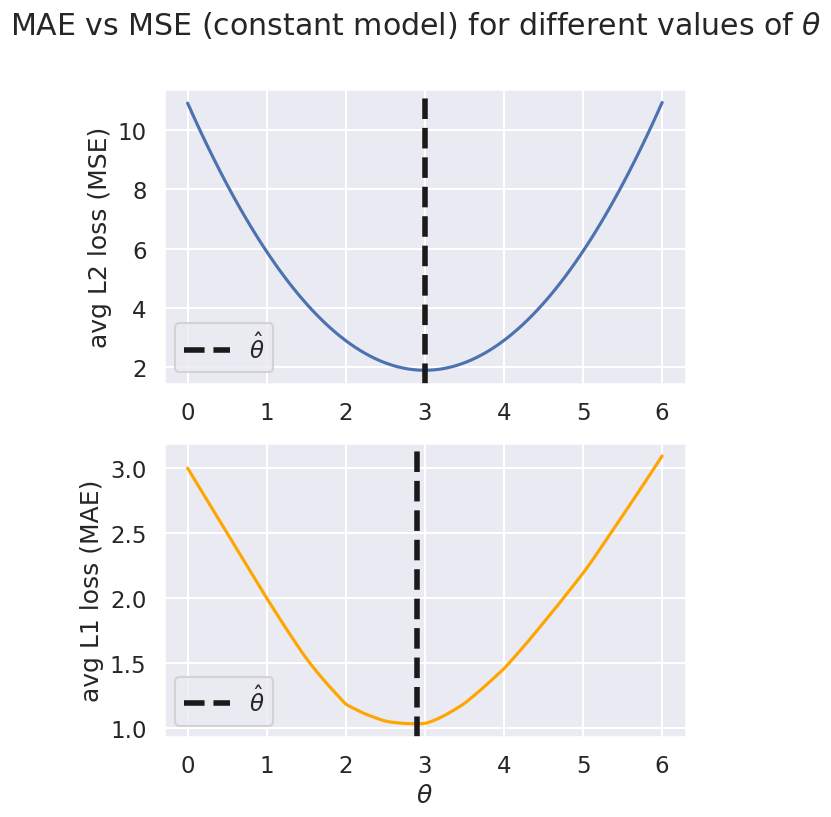

In [75]:
# just run this cell
fig, ax = plt.subplots(nrows=2, figsize=((6, 8)))
theta_values = np.linspace(0, 6, 100)
mse = [mse_tips_constant(theta) for theta in theta_values]
ax[0].plot(theta_values, mse)
ax[0].axvline(x=min_computed, linewidth=4, color='k', ls='--',
              label=r'$\hat{\theta}$')
ax[0].legend()
ax[0].set_ylabel("avg L2 loss (MSE)")

mae = [mae_tips_constant(theta) for theta in theta_values]
ax[1].plot(theta_values, mae, color='orange')
ax[1].axvline(x=min_computed_mae, linewidth=4, color='k', ls='--',
              label=r'$\hat{\theta}$')
ax[1].legend()
ax[1].set_ylabel("avg L1 loss (MAE)")

ax[1].set_xlabel(r'$\theta$');
fig.suptitle(r"MAE vs MSE (constant model) for different values of $\theta$");

**Thought question** You should see that the MAE plot (below) looks somewhat similar the MSE plot (above). Try to identify any key differences you observe and write them down below. This might be more fun with a partner. Note, your answer will not be graded, so don't worry about writing a detailed answer. If you want to see our answer, see the very end of this lab notebook.

_Write your answer here, replacing this text._

# Congratulations! You finished the lab!

# Extra Notes

---

#### Our Observations on Constant Model vs Linear Model

Earlier in this lab, we said we'd describe our observations about whether to use Constant Model or Linear Model (both trained with MSE). Here are some thoughts:

Recall that $r$ is the correlation coefficient, where values closer to -1 or 1 imply a very linear relationship:

In [76]:
# you computed this in Q5a
r

0.6757341092113641

The relationship between $x$ and $y$ is *somewhat* linear; you can see this more clearly through the scatter plot, where there are many points that don't fall close to the linear model line. With this in mind:


* The linear model seems to work well for most bills.
* However, as bills get bigger, some datapoints seem to suggest that the constant model works better.
* In the wild, a tip predictor may use a combination of both the constant and linear models we trained: an average prediction, or a random coin flip to pick the model, or some heuristic decision to choose one model if the total bill exceeds a certain threshold.

In the not-so-distant future of this class, you will learn more quantitative metrics to compare model performance. You will have an opportunity to explore your own models in a future assignment!

---

#### Our Observations on Differences Between MAE vs. MSE

Earlier in this lab, we said we'd describe our observations about the differences between the MAE and MSE.

There are three key differences that we identified between the plots of the MSE and MAE.

1. The minimizing $\theta = \hat{\theta}$ is different.
2. The plot for MAE increases linearly instead of quadratically as we move far away from the minimizing $\theta$.
3. The plot for MAE is piecewise linear instead of smooth. Each change in slope happens at the same $\theta$ value as a data point in our dataset.

---

To double-check your work, the cell below will rerun all of the autograder tests.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**